# 1 Установка библиотек и загрузка моделей. Определение вспомогательных функций

In [1]:
%pip install mediapipe >null

In [2]:
import os
import sys
import requests
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def is_running_in_colab():
    return 'google.colab' in sys.modules

# В зависимости от среды, используйте cv2.imshow или cv2_imshow
if is_running_in_colab():
    from google.colab.patches import cv2_imshow as imshow
    from google.colab import drive
    drive.mount('/content/drive')
else:
    from cv2 import imshow


Mounted at /content/drive


In [3]:
def download_file_from_google_drive(url, destination):
    session = requests.Session()
    response = session.get(url, stream=True)
    token = None

    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            token = value
            break

    if token:
        params = {'id': '1bhEr-cgGeGry3B_PszS2LkA_9-z-wNBi', 'confirm': token}
        response = session.get(url, params=params, stream=True)

    with open(destination, 'wb') as f:
        for chunk in response.iter_content(chunk_size=32768):
            if chunk:
                f.write(chunk)

In [4]:
model_path = '/content'
models = ['pose_landmarker_heavy','pose_landmarker_lite','pose_landmarker_full']
for mod in models:
    fil = mod+'.task'
    url = f'https://storage.googleapis.com/mediapipe-models/pose_landmarker/{mod}/float16/1/{mod}.task'
    if not os.path.exists(fil):
        download_file_from_google_drive(url, fil)


# 1.1 Вспомогательные функции

#1.1.1 Функция визуализация отрисовки  маркеров на обнаруженном человеке

In [5]:
#@markdown  Функция визуализация будет использоваться в этом colab, чтобы лучше продемонстрировать API Pose Landmarker. Они будут рисовать маркеры на обнаруженном человеке, а также ожидаемые связи между этими маркерами.



def _draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [6]:
solutions.drawing_styles.get_default_pose_landmarks_style()

{<PoseLandmark.LEFT_EYE_INNER: 1>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_EYE: 2>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_EYE_OUTER: 3>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_EAR: 7>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.MOUTH_LEFT: 9>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_SHOULDER: 11>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_ELBOW: 13>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_WRIST: 15>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_PINKY: 17>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_INDEX: 19>: DrawingSpec(color=(0, 138, 255), thickness=2, circle_radius=2),
 <PoseLandmark.LEFT_THUMB: 21>: Drawin

In [7]:
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)
    # Создаем объект DrawingSpec для линий (соединений)
    red_color = (0, 0, 255)  # Красный цвет в формате BGR
    line_spec = solutions.drawing_utils.DrawingSpec(color=red_color, thickness=2)

    # Цикл по обнаруженным позам для визуализации
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Преобразование в формат NormalizedLandmarkList
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])

        # Рисуем позы с красными линиями
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style(),
            #landmark_drawing_spec=None,  # Используем стиль по умолчанию для маркеров
            connection_drawing_spec=line_spec)  # Используем наш стиль для линий

    return annotated_image


#1.1.2 Проверка загрузки и отображения тестового кадра

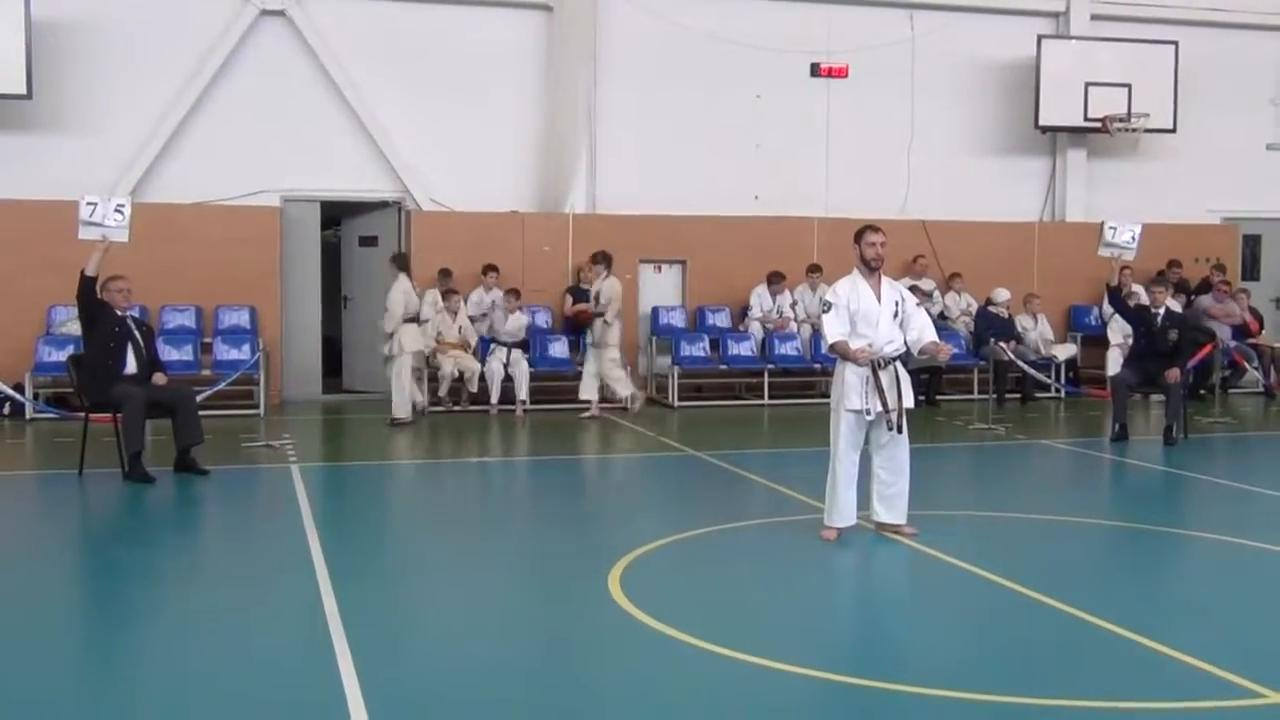

Ширина Высота изображения: (720, 1280, 3)


In [9]:
#!wget -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg
import cv2

url = 'https://drive.google.com/uc?export=download&id=1bhEr-cgGeGry3B_PszS2LkA_9-z-wNBi'
download_file_from_google_drive(url, 'image.jpg')

fname_img='image.jpg'
#fname_img='/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/blaze_sink_ката левая камера_img/blaze_sink_ката левая камера.00119.png'

# Проверка существования файла
if os.path.exists(fname_img):
    # Попытка открыть изображение
    img = cv2.imread(fname_img)

    # Проверка, успешно ли открылось изображение
    if img is not None:
        # Отображение изображения и вывод его размеров
        imshow(img)  # Используем cv2_imshow для отображения изображения в Colab
        print("Ширина Высота изображения:", img.shape)
    else:
        print("Ошибка: Не удалось открыть изображение.")
else:
    print("Ошибка: Файл не найден.")

#1.1.3 Определение позы на фото




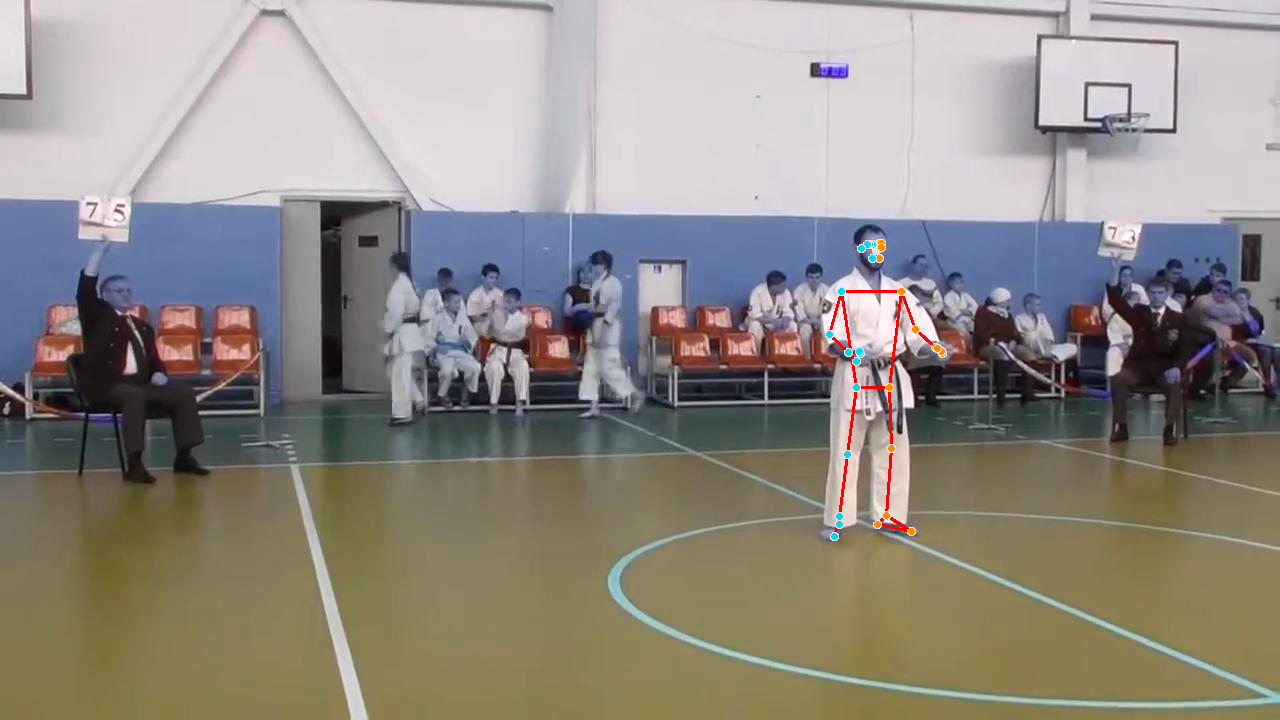

In [11]:
 #STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
# STEP 2: Create an PoseLandmarker object.

base_options = python.BaseOptions(model_asset_path='pose_landmarker_full.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
filename = fname_img #take_photo()
image = mp.Image.create_from_file(filename)#"image.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
#cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


# Проверка, что segmentation_masks существует и не равен None
if detection_result.segmentation_masks is not None:
    segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
    # Теперь вы можете работать с segmentation_mask
    # Например, отобразить маску сегментации
    # cv2_imshow(segmentation_mask)  # Пример отображения маски (если вы используете Google Colab)
else:
    print("Segmentation masks не доступны для данного результата.")


# Предполагается, что annotated_image и segmentation_mask уже определены
# Преобразование annotated_image в формат, совместимый с NumPy, если это необходимо
annotated_image = annotated_image.numpy_view() if not isinstance(annotated_image, np.ndarray) else annotated_image
height, width = annotated_image.shape[:2] # Размеры изображения
# Преобразование и масштабирование маски сегментации к размерам изображения
#segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
#segmentation_mask_resized = cv2.resize(1-segmentation_mask, (width, height))
#visualized_mask = np.repeat(segmentation_mask_resized[:, :, np.newaxis], 3, axis=2)
# Преобразование маски в формат BGR для визуализации
#visualized_mask = (visualized_mask * 255).astype(np.uint8)
# Наложение маски на изображение
# Можно настроить уровень прозрачности (alpha) по желанию
#alpha = 0.4
#combined_image = cv2.addWeighted(annotated_image, 1 - alpha, visualized_mask, alpha, 0)

# Отображение результата
imshow(annotated_image)

#display(detection_result)

In [12]:
#detection_result[0].world_landmarks
print (detection_result.pose_world_landmarks[:][:],"\n")
for index, landmark in enumerate(detection_result.pose_world_landmarks[0][:]):
    print(f"{index}: {landmark}\n")


[[Landmark(x=0.02720000594854355, y=-0.6624472737312317, z=-0.22172798216342926, visibility=0.9999339580535889, presence=0.9998403787612915), Landmark(x=0.02456723153591156, y=-0.6996649503707886, z=-0.2002825289964676, visibility=0.9998817443847656, presence=0.999582827091217), Landmark(x=0.024917490780353546, y=-0.7002485990524292, z=-0.1996251791715622, visibility=0.9998418092727661, presence=0.9995540976524353), Landmark(x=0.024663344025611877, y=-0.7007272839546204, z=-0.19965830445289612, visibility=0.9998224377632141, presence=0.9995148181915283), Landmark(x=-0.005183398723602295, y=-0.694209635257721, z=-0.20822814106941223, visibility=0.9998912811279297, presence=0.999639630317688), Landmark(x=-0.004767328500747681, y=-0.6950253844261169, z=-0.20891182124614716, visibility=0.9998756647109985, presence=0.9996140599250793), Landmark(x=-0.005003981292247772, y=-0.696349561214447, z=-0.20811277627944946, visibility=0.9998708963394165, presence=0.99958735704422), Landmark(x=0.04462

In [13]:
pip install plotly


In [14]:
import plotly.graph_objs as go

# Предположим, что detection_result.pose_world_landmarks[0] содержит список объектов Landmark.
landmarks_data = detection_result.pose_world_landmarks[0]

# Извлечение координат x, y, z из каждого Landmark и подготовка текста с номерами точек.
x = [landmark.x for landmark in landmarks_data]
y = [landmark.y for landmark in landmarks_data]
z = [landmark.z for landmark in landmarks_data]
text = [f'{i}' for i in range(len(landmarks_data))]

# Создание трассировки для точек.
print(x,'\n',y,'\n',z)
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers+text',
    marker=dict(
        size=5,
        color='red',  # Цвет точек - красный
    ),
    text=text,  # Номера точек
    textposition='top center'
)

# Определение макета графика.
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Создание фигуры и отображение графика.
fig = go.Figure(data=[trace], layout=layout)
fig.show()


[0.02720000594854355, 0.02456723153591156, 0.024917490780353546, 0.024663344025611877, -0.005183398723602295, -0.004767328500747681, -0.005003981292247772, 0.04462762176990509, -0.09144990891218185, 0.039802223443984985, -0.0004410669207572937, 0.14108768105506897, -0.17432034015655518, 0.19165772199630737, -0.23885202407836914, 0.3034396171569824, -0.12545473873615265, 0.33192920684814453, -0.08183138072490692, 0.32931283116340637, -0.05550742894411087, 0.3035370707511902, -0.10025469958782196, 0.1055583581328392, -0.10570621490478516, 0.11620088666677475, -0.130852609872818, 0.12024949491024017, -0.16328378021717072, 0.1310284286737442, -0.16734875738620758, 0.2352609634399414, -0.17612022161483765] 
 [-0.6624472737312317, -0.6996649503707886, -0.7002485990524292, -0.7007272839546204, -0.694209635257721, -0.6950253844261169, -0.696349561214447, -0.6855567097663879, -0.6673804521560669, -0.6369898915290833, -0.6300975680351257, -0.5025712847709656, -0.482616126537323, -0.3034185469150

In [15]:
import plotly.graph_objs as go

# Предположим, что detection_result.pose_world_landmarks[0] содержит список объектов Landmark.
landmarks_data = detection_result.pose_world_landmarks[0]

# Извлечение координат x, y, z из каждого Landmark.
x = [landmark.x for landmark in landmarks_data]
y = [landmark.y for landmark in landmarks_data]
z = [landmark.z for landmark in landmarks_data]

# Подготовка данных для трассировки точек.
trace_points = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers+text',
    marker=dict(
        size=5,
        color='red',
    ),
    text=[f'{i}' for i in range(len(landmarks_data))],
    textposition='top center'
)


tracepoints = [
    # Соединения верхней части тела (например, плечи, локти, запястья)
    [9, 10],
    [0, 5],[5, 8],
    [0, 2],[2, 7],
    [11, 13], [13, 15],  # Левая рука (плечо-локоть, локоть-запястье)
    [12, 14], [14, 16],  # Правая рука
    [11, 12],            # Плечи
    [23, 24],            #  Таз (начало СК)
    [24, 26],[26, 28],[28, 30],[30, 32],[28, 32],  # Левая нога (бедро-колено, колено-лодыжка)
    [23, 25], [25, 27],[27, 29],[27, 31],[29, 31],  # Правая нога
    # Другие соединения (например, позвоночник, бедра)
    [11, 23], [12, 24],   # Соединения плеча с бедрами
    # Добавьте другие соединения по необходимости
    [15, 17], [15, 19], [15, 21],[19, 17], # Левая рука: запястье (15) к основанию каждого пальца
    [16, 18], [16, 20], [16, 22],[18, 20]  # Правая рука: запястье (16) к основанию каждого пальца
    ]
# Примечание: Индексы в tracepoints должны соответствовать реальным индексам в pose_world_landmarks



# Создание линий для каждого соединения.
lines = []
for tp in tracepoints:
    line = go.Scatter3d(
        x=[x[tp[0]], x[tp[1]]],
        y=[y[tp[0]], y[tp[1]]],
        z=[z[tp[0]], z[tp[1]]],
        mode='lines',
        line=dict(
            color='blue',
            width=2
        )
    )
    lines.append(line)

# Определение макета графика.
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Создание фигуры и отображение графика.
fig = go.Figure(data=[trace_points, *lines], layout=layout)
fig.show()


In [17]:
class TRCConverter:
    def __init__(self):
        self.header_written = False
        self.frame_number = 1
        # Define the order of markers based on the provided MediaPipe numbering scheme
        self.marker_order = [
            "right_shoulder", "right_elbow", "right_wrist", "right_pinky", "right_index",
            "right_thumb", "right_hip", "right_knee", "right_ankle", "right_heel",
            "right_foot_index", "left_shoulder", "left_elbow", "left_wrist", "left_pinky",
            "left_index", "left_thumb", "left_hip", "left_knee", "left_ankle", "left_heel",
            "left_foot_index", "nose", "left_eye", "right_eye"
        ]

    def get_header(self):
        header_lines = [
            "PathFileType\t4\t(X/Y/Z)\tKata_2Dto3D_0-1123.trc",
            "DataRate\tCameraRate\tNumFrames\tNumMarkers\tUnits\tOrigDataRate\tOrigDataStartFrame\tOrigNumFrames",
            f"30\t30\t1123\t{len(self.marker_order)}\tm\t30\t0\t1123"
        ]
        # Include the numeric labels for the second line of headers
        numeric_labels = "\t\t" + "\t\t\t".join([f"X{i+1}\tY{i+1}\tZ{i+1}" for i in range(len(self.marker_order))])
        # Column headers for the markers
        column_headers = "Frame#\tTime\t" + "\t\t\t".join(self.marker_order)
        self.header_written = True
        return "\n".join(header_lines + [column_headers, numeric_labels])

    def convert_landmarks_to_row(self, landmarks):
        # Calculate the time for the given frame number
        time = self.frame_number / 30.0  # Assuming 30 FPS
        row = [str(self.frame_number), "{:.5f}".format(time)]
        for lm in landmarks:
            # Append the x, y, z values of each landmark to the row
            row.extend(["{:.7f}".format(lm.x), "{:.7f}".format(lm.y), "{:.7f}".format(lm.z)])
        self.frame_number += 1
        return "\t".join(row)

    def convert_to_trc(self, pose_landmarks):
        # Generate header if it's the first call
        header = self.get_header() if not self.header_written else ""
        # Convert landmarks to .trc row format
        trc_row = self.convert_landmarks_to_row(pose_landmarks)
        # Return header and row combined if header was generated, else just the row
        return (header + "\n" if header else "") + trc_row + "\n"

# Example usage with a structure as input instead of a string
# Suppose pose_landmarks is a list of Landmark namedtuples as defined above


converter = TRCConverter()
output = converter.convert_to_trc(detection_result.pose_world_landmarks[0][:])
print(output)


PathFileType	4	(X/Y/Z)	Kata_2Dto3D_0-1123.trc
DataRate	CameraRate	NumFrames	NumMarkers	Units	OrigDataRate	OrigDataStartFrame	OrigNumFrames
30	30	1123	25	m	30	0	1123
Frame#	Time	right_shoulder			right_elbow			right_wrist			right_pinky			right_index			right_thumb			right_hip			right_knee			right_ankle			right_heel			right_foot_index			left_shoulder			left_elbow			left_wrist			left_pinky			left_index			left_thumb			left_hip			left_knee			left_ankle			left_heel			left_foot_index			nose			left_eye			right_eye
		X1	Y1	Z1			X2	Y2	Z2			X3	Y3	Z3			X4	Y4	Z4			X5	Y5	Z5			X6	Y6	Z6			X7	Y7	Z7			X8	Y8	Z8			X9	Y9	Z9			X10	Y10	Z10			X11	Y11	Z11			X12	Y12	Z12			X13	Y13	Z13			X14	Y14	Z14			X15	Y15	Z15			X16	Y16	Z16			X17	Y17	Z17			X18	Y18	Z18			X19	Y19	Z19			X20	Y20	Z20			X21	Y21	Z21			X22	Y22	Z22			X23	Y23	Z23			X24	Y24	Z24			X25	Y25	Z25
1	0.03333	0.0272000	-0.6624473	-0.2217280	0.0245672	-0.6996650	-0.2002825	0.0249175	-0.7002486	-0.1996252	0.0246633	-0.7007273	-0.1996583	-0.0051834	-0.6942096	-0.2082

In [18]:
import re
from collections import namedtuple

# Define a namedtuple for storing landmark data
Landmark = namedtuple('Landmark', ['x', 'y', 'z', 'visibility', 'presence'])

class TRCConverter:
    def __init__(self):
        self.header_written = False
        self.frame_number = 1
        self.marker_order = [
            "nose", "left_eye_inner", "left_eye", "left_eye_outer", "right_eye_inner", "right_eye",
            "right_eye_outer", "left_ear", "right_ear", "mouth_left", "mouth_right", "left_shoulder",
            "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_pinky",
            "right_pinky", "left_index", "right_index", "left_thumb", "right_thumb", "left_hip",
            "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle", "left_heel",
            "right_heel", "left_foot_index", "right_foot_index"
        ]

    def get_header(self):
        header_lines = [
            "PathFileType\t4\t(X/Y/Z)\tKata_2Dto3D_0-1123.trc",
            "DataRate\tCameraRate\tNumFrames\tNumMarkers\tUnits\tOrigDataRate\tOrigDataStartFrame\tOrigNumFrames",
            f"30\t30\t1123\t{len(self.marker_order)}\tm\t30\t0\t1123",
            "\t".join(["Frame#\tTime"] + ["\t".join([f"{marker}_{axis}" for axis in ["X", "Y", "Z"]]) for marker in self.marker_order]) + "\t\t\t"
        ]
        self.header_written = True
        return "\n".join(header_lines)

    def convert_landmarks_to_row(self, landmarks):
        # Calculate the time for the given frame number
        time = self.frame_number / 30.0  # Assuming 30 FPS
        row = [str(self.frame_number), "{:.5f}".format(time)]
        for lm in landmarks:
            # Append the x, y, z values of each landmark to the row
            row.extend(["{:.7f}".format(lm.x), "{:.7f}".format(lm.y), "{:.7f}".format(lm.z)])
        self.frame_number += 1
        return "\t".join(row)

    def convert_to_trc(self, pose_landmarks):
        # Generate header if it's the first call
        header = self.get_header() if not self.header_written else ""
        # Convert landmarks to .trc row format
        trc_row = self.convert_landmarks_to_row(pose_landmarks)
        # Return header and row combined if header was generated, else just the row
        return (header + "\n" if header else "") + trc_row + "\n"

# Example usage with a structure as input instead of a string
# Suppose pose_landmarks is a list of Landmark namedtuples as defined above
pose_landmarks = [
    Landmark(x=0.46085062623023987, y=0.2050727903842926, z=-0.8027356863021851, visibility=0.9998942613601685, presence=0.9999738931655884),
    # ... Add all other landmarks in the same order as the MediaPipe numbering scheme
]

converter = TRCConverter()
#output = converter.convert_to_trc(pose_landmarks)
output = converter.convert_to_trc(detection_result.pose_world_landmarks[0])
print(output)


PathFileType	4	(X/Y/Z)	Kata_2Dto3D_0-1123.trc
DataRate	CameraRate	NumFrames	NumMarkers	Units	OrigDataRate	OrigDataStartFrame	OrigNumFrames
30	30	1123	33	m	30	0	1123
Frame#	Time	nose_X	nose_Y	nose_Z	left_eye_inner_X	left_eye_inner_Y	left_eye_inner_Z	left_eye_X	left_eye_Y	left_eye_Z	left_eye_outer_X	left_eye_outer_Y	left_eye_outer_Z	right_eye_inner_X	right_eye_inner_Y	right_eye_inner_Z	right_eye_X	right_eye_Y	right_eye_Z	right_eye_outer_X	right_eye_outer_Y	right_eye_outer_Z	left_ear_X	left_ear_Y	left_ear_Z	right_ear_X	right_ear_Y	right_ear_Z	mouth_left_X	mouth_left_Y	mouth_left_Z	mouth_right_X	mouth_right_Y	mouth_right_Z	left_shoulder_X	left_shoulder_Y	left_shoulder_Z	right_shoulder_X	right_shoulder_Y	right_shoulder_Z	left_elbow_X	left_elbow_Y	left_elbow_Z	right_elbow_X	right_elbow_Y	right_elbow_Z	left_wrist_X	left_wrist_Y	left_wrist_Z	right_wrist_X	right_wrist_Y	right_wrist_Z	left_pinky_X	left_pinky_Y	left_pinky_Z	right_pinky_X	right_pinky_Y	right_pinky_Z	left_index_X	left_index_Y	left_

In [19]:
pose_landmarks

[Landmark(x=0.46085062623023987, y=0.2050727903842926, z=-0.8027356863021851, visibility=0.9998942613601685, presence=0.9999738931655884)]

Pose ID: 0, Bounding Box: (795, 156, 976, 623)


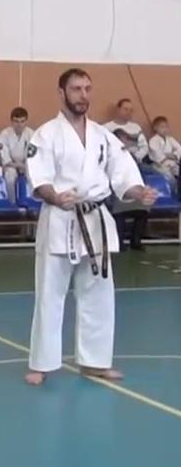

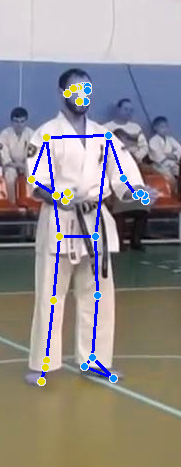

PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.45721787214279175, y=0.19984233379364014, z=-0.8737232685089111, visibility=0.9999226331710815, presence=0.9992976188659668), NormalizedLandmark(x=0.4632832407951355, y=0.1859290897846222, z=-0.8012972474098206, visibility=0.9998890161514282, presence=0.9983495473861694), NormalizedLandmark(x=0.4717079997062683, y=0.18577927350997925, z=-0.8013225197792053, visibility=0.9998694658279419, presence=0.9984431862831116), NormalizedLandmark(x=0.48073405027389526, y=0.1857210397720337, z=-0.8010704517364502, visibility=0.9998549222946167, presence=0.9984452128410339), NormalizedLandmark(x=0.4329594075679779, y=0.18783354759216309, z=-0.8362032175064087, visibility=0.9999011754989624, presence=0.9982742071151733), NormalizedLandmark(x=0.4185020923614502, y=0.18911603093147278, z=-0.8362395763397217, visibility=0.999887228012085, presence=0.998163640499115), NormalizedLandmark(x=0.4039897322654724, y=0.19044363498687744, z=-0.8363790

In [22]:
import cv2
import numpy as np
from mediapipe.framework.formats import landmark_pb2

def adjust_contrast_and_white_balance(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    # Преобразование изображения в LAB для настройки баланса белого
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Разделение на каналы
    l, a, b = cv2.split(lab)

    # Применение CLAHE к каналу L (светлости)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l = clahe.apply(l)

    # Объединение каналов обратно в LAB и конвертация в BGR
    lab = cv2.merge((l, a, b))
    adjusted_image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    return adjusted_image


def crop_poses_from_image(rgb_image, detection_result, padding_percent=30):
    h, w, _ = rgb_image.shape
    cropped_images_info = []

    # Перебираем все обнаруженные позы
    for pose_id, pose_landmarks in enumerate(detection_result.pose_landmarks):
        x_min = y_min = np.inf
        x_max = y_max = -np.inf

        # Обрабатываем каждую позу отдельно
        for landmark in pose_landmarks:
            x, y = landmark.x, landmark.y
            x_min = min(x, x_min)
            x_max = max(x, x_max)
            y_min = min(y, y_min)
            y_max = max(y, y_max)

        # Расширяем границы
        x_padding = (x_max - x_min) * padding_percent / 100
        y_padding = (y_max - y_min) * padding_percent / 100
        x_min = max(x_min - x_padding, 0)
        y_min = max(y_min - y_padding, 0)
        x_max = min(x_max + x_padding, 1)
        y_max = min(y_max + y_padding, 1)

        # Переводим координаты в пиксели и вырезаем изображение
        x_min_pixel = int(x_min * w)
        y_min_pixel = int(y_min * h)
        x_max_pixel = int(x_max * w)
        y_max_pixel = int(y_max * h)
        cropped_image = rgb_image[y_min_pixel:y_max_pixel, x_min_pixel:x_max_pixel]

        # Сохраняем информацию о вырезанном изображении
        cropped_images_info.append({
            'pose_id': pose_id,
            'bounding_box': (x_min_pixel, y_min_pixel, x_max_pixel, y_max_pixel),
            'cropped_image': cropped_image
        })

    return cropped_images_info



def crop_pose_from_image(rgb_image, detection_result, padding_percent=20):
    pose_landmarks_list = detection_result.pose_landmarks
    h, w, _ = rgb_image.shape

    # Инициализируем минимальные и максимальные значения координат
    x_min = y_min = np.inf
    x_max = y_max = -np.inf

    # Перебираем все обнаруженные позы
    for pose_landmarks in pose_landmarks_list:
        for landmark in pose_landmarks:
            x, y = landmark.x, landmark.y
            # Обновляем минимальные и максимальные значения
            if x < x_min:
                x_min = x
            if x > x_max:
                x_max = x
            if y < y_min:
                y_min = y
            if y > y_max:
                y_max = y

    # Расширяем границы на 10%
    x_padding = (x_max - x_min) * padding_percent / 100
    y_padding = (y_max - y_min) * padding_percent / 100

    x_min = max(x_min - x_padding, 0)
    y_min = max(y_min - y_padding, 0)
    x_max = min(x_max + x_padding, 1)
    y_max = min(y_max + y_padding, 1)

    # Переводим координаты в пиксели
    x_min_pixel = int(x_min * w)
    y_min_pixel = int(y_min * h)
    x_max_pixel = int(x_max * w)
    y_max_pixel = int(y_max * h)

    # Вырезаем область с позой
    cropped_image = rgb_image[y_min_pixel:y_max_pixel, x_min_pixel:x_max_pixel]
    return cropped_image

# Загрузка входного изображения из файла, указанного в переменной fname_img
input_image = cv2.imread(fname_img)
# Проверка, успешно ли загружено изображение
if input_image is None:
    print("Ошибка загрузки изображения. Проверьте путь к файлу:", fname_img)
else:

    # Предположим, что detection_result - это ваш результат обнаружения позы
    #detection_result = # ваш результат обнаружения позы...

    # Вырезаем изображение с позой
    #cropped_image = crop_pose_from_image(input_image, detection_result)
    res_cropped =crop_poses_from_image(input_image, detection_result)

    for pose_info in res_cropped:
        pose_id = pose_info['pose_id']
        bounding_box = pose_info['bounding_box']
        cropped_image = pose_info['cropped_image']
        # Теперь вы можете использовать pose_id, bounding_box и cropped_image
        # Например, выводим ID позы и координаты баундинг-бокса
        print(f"Pose ID: {pose_id}, Bounding Box: {bounding_box}")
        # Для визуализации вырезанного изображения можно использовать cv2.imshow или другие методы
        #cv2.imshow(f"Pose {pose_id}", cropped_image)
        imshow(cropped_image)  # Отображаем его с помощью функции cv2_imshow
        cv2.waitKey(0)

        # STEP 2: Create an PoseLandmarker object.
        if 'detector' not in locals():
            base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
            options = vision.PoseLandmarkerOptions(
                base_options=base_options,
                output_segmentation_masks=False)
            detector = vision.PoseLandmarker.create_from_options(options)

        # STEP 4: Detect pose landmarks from the input image.
        # Убедитесь, что изображение в формате RGB
        #cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        # Convert the frame received from OpenCV to a MediaPipe’s Image object.
        # Предположим, что cropped_image - это ваш обрезанный массив ndarray
        # Проверяем тип данных
        if cropped_image.dtype != np.uint8:
            cropped_image = cropped_image.astype(np.uint8)

        # Теперь создаем объект Image в MediaPipe
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
        detection_result1 = detector.detect(mp_image)

        # STEP 5: Process the detection result. In this case, visualize it.
        annotated_image1 = draw_landmarks_on_image(cropped_image, detection_result1)
        imshow(cv2.cvtColor(annotated_image1, cv2.COLOR_RGB2BGR))
        #display(detection_result)
        display(detection_result1)





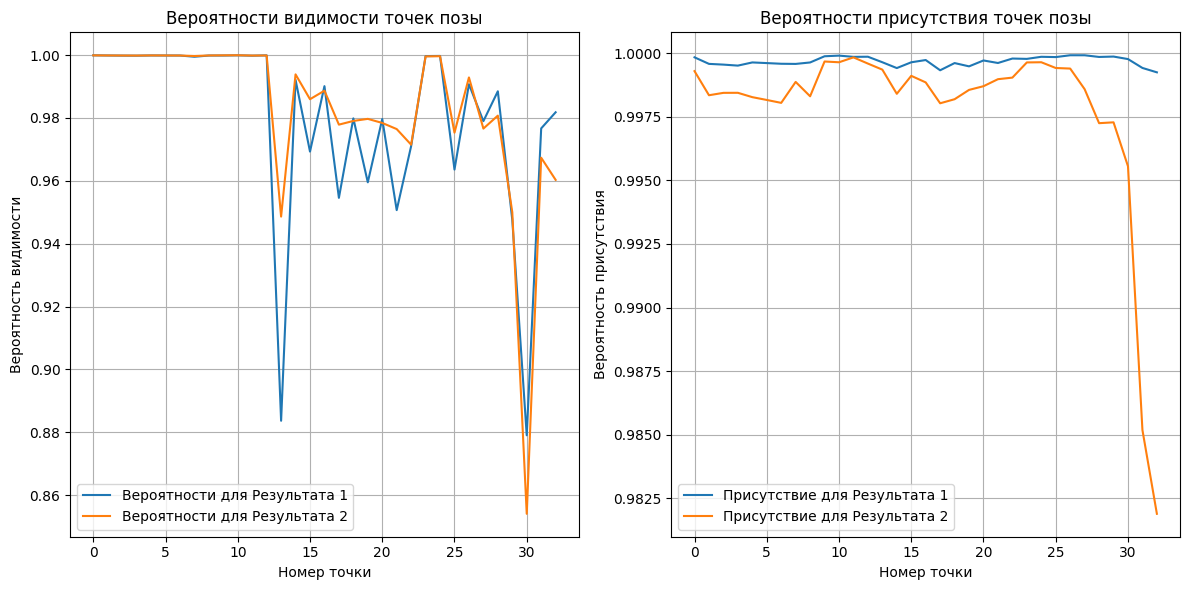

Presence Values: 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00
Presence Values: 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 0.98
visibility_values_1: 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.88, 0.99, 0.97, 0.99, 0.95, 0.98, 0.96, 0.98, 0.95, 0.97, 1.00, 1.00, 0.96, 0.99, 0.98, 0.99, 0.95, 0.88, 0.98, 0.98
visibility_values_2: 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 0.95, 0.99, 0.99, 0.99, 0.98, 0.98, 0.98, 0.98, 0.98, 0.97, 1.00, 1.00, 0.98, 0.99, 0.98, 0.98, 0.95, 0.85, 0.97, 0.96


In [23]:
import matplotlib.pyplot as plt
def extract_visibility_and_presence_values(det_result):
    # Извлекаем список точек позы из результата
    landmarks = det_result.pose_landmarks[0]  # Предполагаем, что результат содержит один список точек позы

    # Извлекаем значения видимости и присутствия
    visibility_values = [landmark.visibility for landmark in landmarks]
    presence_values = [landmark.presence for landmark in landmarks]
    return visibility_values, presence_values

# Предположим, что у вас есть три detection_result с разными значениями вероятностей
# Замените следующие строки на реальные данные из ваших detection_result
detection_result_1 =detection_result # Ваш первый результат обнаружения позы
detection_result_2 =detection_result1 # Ваш второй результат обнаружения позы
#3detection_result_3 =detection_result2 # Ваш третий результат обнаружения позы

# Извлекаем значения вероятностей и присутствия
visibility_values_1, presence_values_1 = extract_visibility_and_presence_values(detection_result_1)
visibility_values_2, presence_values_2 = extract_visibility_and_presence_values(detection_result_2)
#visibility_values_3, presence_values_3 = extract_visibility_and_presence_values(detection_result_3)

# Определяем длину списка точек позы
num_points = len(detection_result_1.pose_landmarks[0])

# Номера точек для оси X
point_numbers = list(range(num_points))

# Отрисовка графика для видимости и присутствия
plt.figure(figsize=(12, 6))

# Видимость
plt.subplot(1, 2, 1)
plt.plot(point_numbers, visibility_values_1, label='Вероятности для Результата 1')
plt.plot(point_numbers, visibility_values_2, label='Вероятности для Результата 2')
#plt.plot(point_numbers, visibility_values_3, label='Вероятности для Результата 3')
plt.xlabel('Номер точки')
plt.ylabel('Вероятность видимости')
plt.title('Вероятности видимости точек позы')
plt.legend()
plt.grid()

# Присутствие
plt.subplot(1, 2, 2)
plt.plot(point_numbers, presence_values_1, label='Присутствие для Результата 1')
plt.plot(point_numbers, presence_values_2, label='Присутствие для Результата 2')
#plt.plot(point_numbers, presence_values_3, label='Присутствие для Результата 3')
plt.xlabel('Номер точки')
plt.ylabel('Вероятность присутствия')
plt.title('Вероятности присутствия точек позы')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

formatted_values = [f"{value:.2f}" for value in presence_values_1]
print(f"Presence Values: {', '.join(formatted_values)}")
formatted_values = [f"{value:.2f}" for value in presence_values_2]
print(f"Presence Values: {', '.join(formatted_values)}")
#formatted_values = [f"{value:.2f}" for value in presence_values_3]
#print(f"Presence Values: {', '.join(formatted_values)}")

formatted_values = [f"{value:.2f}" for value in visibility_values_1]
print(f"visibility_values_1: {', '.join(formatted_values)}")
formatted_values = [f"{value:.2f}" for value in visibility_values_2]
print(f"visibility_values_2: {', '.join(formatted_values)}")
#formatted_values = [f"{value:.2f}" for value in visibility_values_3]
#print(f"visibility_values_3: {', '.join(formatted_values)}")


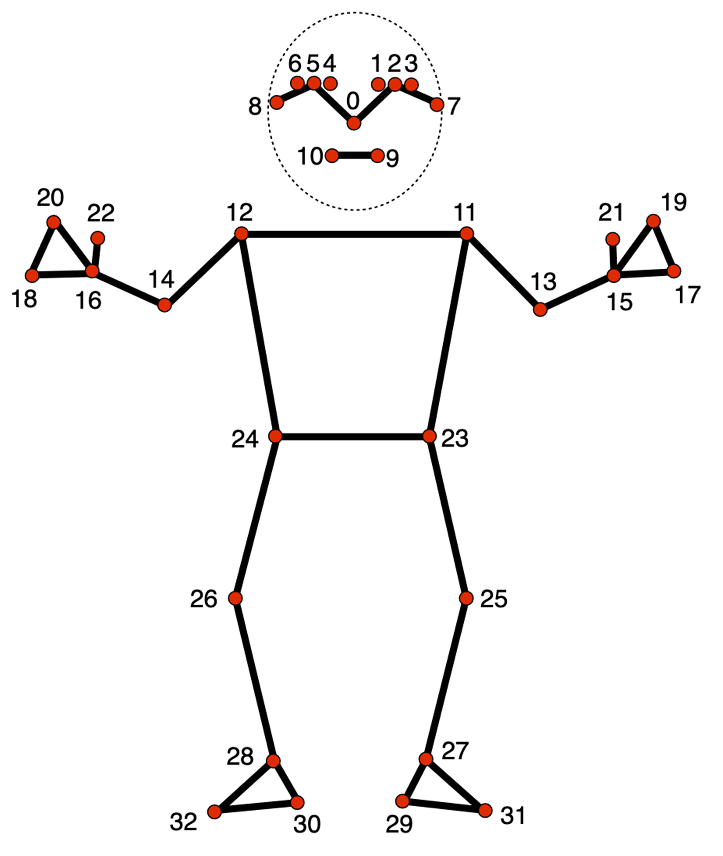

In [25]:
import cv2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

is_initialized = False
detector = None


def initialize_pose_landmarker(model_complexity=0):
    # Инициализация PoseLandmarker
    if model_complexity == 0 : model_asset_path='pose_landmarker_lite.task'
    if model_complexity == 1 : model_asset_path='pose_landmarker_full.task'
    if model_complexity == 2 : model_asset_path='pose_landmarker_heavy.task'
    else : model_asset_path='pose_landmarker_lite.task'

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

# Create a pose landmarker instance with the video mode:
    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_asset_path),
        #running_mode=VisionRunningMode.VIDEO,
        output_segmentation_masks=False,  # Включить или отключить вывод сегментационных масок
        min_pose_detection_confidence=0.5,    # Минимальная уверенность для детектирования (0.0-1.0)
        min_pose_presence_confidence=0.5,      # Минимальная уверенность для отслеживания (0.0-1.0)
        num_poses=1
        )


    detector = vision.PoseLandmarker.create_from_options(options)
    return detector

def adjust_pose_coordinates(pose_landmarks, bounding_box, full_image_width, full_image_height):
    x_min, y_min, x_max, y_max = bounding_box
    cropped_width = x_max - x_min
    cropped_height = y_max - y_min

    for landmark in pose_landmarks[0]:  # Обращаемся к первому элементу списка pose_landmarks
        # Пересчитываем координаты в пикселях для большого кадра
        pixel_x = landmark.x * cropped_width + x_min
        pixel_y = landmark.y * cropped_height + y_min
        # Нормализуем координаты относительно большого кадра
        landmark.x = pixel_x / full_image_width
        landmark.y = pixel_y / full_image_height
        # Z координата остается неизменной и нормализованной, так как она относительная
        # landmark.z остается неизменным



def process_image(in_img,model_complexity=0, out_anot_img=True, stage2=False,show_res=False):
    global is_initialized, detector

    # Инициализация при первом вызове
    if (not is_initialized):
        detector = initialize_pose_landmarker(model_complexity=model_complexity)
        is_initialized = True
    #print(in_img)
    if in_img.dtype != np.uint8: in_img = in_img.astype(np.uint8)  # Проверяем тип данных
    mp_image_in = mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB))
    detection_result1 = detector.detect(mp_image_in)
    # Проверка, были ли обнаружены какие-либо позы
    if not detection_result1 or not detection_result1.pose_landmarks:
       print("Ошибка: в кадре не обнаружены позы.")
       print(detection_result1)
       return False
    else:
        if show_res: print("in_img.shape",in_img.shape) ;print(detection_result1)
        # Визуализация позы на кадре (если включена).
        annotated_image1 = draw_landmarks_on_image(in_img, detection_result1)
        if show_res:
            #cv2.imshow('Annotated Image', cv2.cvtColor(annotated_image1, cv2.COLOR_RGB2BGR))
            #cv2_imshow(cv2.cvtColor(annotated_image1, cv2.COLOR_RGB2BGR))
            imshow(annotated_image1)
            # Пример использования
            #imshow(annotated_image1)
        if stage2:
        # Вырезаем изображение с позой
           res_cropped = crop_poses_from_image(in_img, detection_result1)
           all_pose_results = []  # Для хранения результатов всех поз

           for pose_info in res_cropped:
            pose_id = pose_info['pose_id']
            bounding_box = pose_info['bounding_box']
            cropped_image = pose_info['cropped_image']
            if cropped_image.dtype != np.uint8: cropped_image = cropped_image.astype(np.uint8)  # Проверяем тип данных
            # Повторное обнаружение позы в фрагменте баундбокса
            detection_result2 = detector.detect(mp.Image(image_format=mp.ImageFormat.SRGB, data=cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)))
            # Пересчет координат точек позы
            #adjusted_pose = adjust_pose_coordinates(detection_result2.pose_landmarks, bounding_box)
            #display(detection_result2)
            if show_res:
                annotated_image2 = draw_landmarks_on_image(cropped_image, detection_result2)
                #cv2.imshow(f"Pose {pose_id}", cv2.cvtColor(annotated_image2, cv2.COLOR_RGB2BGR))
                print(f"Pose {pose_id}")
                imshow(annotated_image2)
                display(detection_result2)

            adjust_pose_coordinates(detection_result2.pose_landmarks, bounding_box, in_img.shape[1], in_img.shape[0])

            #display(detection_result2)
            # Сохранение результата для каждой обнаруженной позы
            #all_pose_results.append({'pose_id': pose_id, 'pose_landmarks': adjusted_pose})
            if out_anot_img:
                annotated_image2 = draw_landmarks_on_image(in_img, detection_result2)
                #cv2.imshow(f"Pose {pose_id}", cv2.cvtColor(annotated_image2, cv2.COLOR_RGB2BGR))
                if show_res:
                    print(f"Pose {pose_id}")
                    cv2_imshow(annotated_image2)
                    display(detection_result2)
        #print(annotated_image2)
            return all_pose_results, annotated_image2
        else:
           return detection_result1, annotated_image1
debug= True
# Пример вызова функции
if debug:
  filename = fname_img  # Путь к файлу изображения
  print(filename)
  image = cv2.imread(fname_img)
  imshow(img)
  print("Модель 0. Ширина Высота изображения:", img.shape)
  process_image_res,anot_img = process_image(image,model_complexity=0,stage2=False, show_res=False)
  imshow(anot_img)
  print("Модель=1  Ширина Высота изображения:", img.shape)
  process_image_res,anot_img = process_image(image,model_complexity=1, show_res=False)
  imshow(anot_img)
  print("Модель=2  Ширина Высота изображения:", img.shape)
  process_image_res,anot_img = process_image(image,model_complexity=2, show_res=False)
  imshow(anot_img)

Output hidden; open in https://colab.research.google.com to view.

#2 Обработка поз функциями MediaPipe
 =============================================================================

#2.1 Обработка видеофайлов  в MP

In [26]:
import os

def add_prefix_to_filename(file_path, prefix):
    # Разделяем путь к файлу на части
    directory, filename = os.path.split(file_path)
    # Добавляем префикс к имени файла
    new_filename = prefix + filename
    # Собираем обратно полный путь с новым именем файла
    new_file_path = os.path.join(directory, new_filename)
    return new_file_path


#videof_path='/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/sink_ката правая камера.mp4'
#add_prefix_to_filename(videof_path, "pose_")

In [30]:
#!wget -q -O 'test_video.mp4' 'https://drive.google.com/uc?export=download&id=1aVxDud1ngqYBY-aIQmg4EGvmrLqD5ed2'

import cv2
import time

videof_path='/content/drive/MyDrive/sd/20240209_181457.mp4'
#videof_path='/content/test_video.mp4'

Mod_cmplx=2
for Mod_cmplx in range(2,3):
  is_initialized=False
  # Открыть входное видео
  cap = cv2.VideoCapture(videof_path)
  # Проверить, успешно ли открыт входной файл
  if not cap.isOpened():
      print(f"Ошибка: не удалось открыть видеофайл '{video_path}'.")
      exit()
  # Параметры для создания выходного видео
  #fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  fps = cap.get(cv2.CAP_PROP_FPS)
  width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  #out = cv2.VideoWriter(add_prefix_to_filename(videof_path, "pose_"), fourcc, fps, (width, height))
  out = cv2.VideoWriter(f"out_Mod_cmplx{Mod_cmplx}.mp4", fourcc, fps, (width, height))

  # Цикл по кадрам входного видео
  Nframe=0 ; processing_time=0
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          break
      start_time = time.time()  # Начальное время перед обработкой кадра
      Nframe +=1
      print(Nframe , ret, processing_time)

      # Обработка кадра
      show_res=False ;
      if Nframe == 647 :   show_res=True

      result = process_image(frame,model_complexity=Mod_cmplx, show_res=show_res)
      end_time = time.time()  # Конечное время после обработки кадра
      processing_time = end_time - start_time  # Время обработки кадра
      if not result :
            processed_frame=frame
      else:   processed_frame= result[1]
      # Запись обработанного кадра в выходной файл
      #all_pose_results, annotated_image2
    # Наносим текст на кадр
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(processed_frame, f'Frame {Nframe} Mod cmplx {Mod_cmplx}  Tproc {processing_time:5.3}', (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

      out.write(processed_frame)

  # Освобождение ресурсов
  cap.release()
  out.release()

1 True 0
Ошибка: в кадре не обнаружены позы.
PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
2 True 0.38402771949768066
Ошибка: в кадре не обнаружены позы.
PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
3 True 0.05489969253540039
Ошибка: в кадре не обнаружены позы.
PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
4 True 0.05595564842224121
Ошибка: в кадре не обнаружены позы.
PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
5 True 0.05351543426513672
Ошибка: в кадре не обнаружены позы.
PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
6 True 0.04732227325439453
Ошибка: в кадре не обнаружены позы.
PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
7 True 0.06673336029052734
Ошибка: в кадре не обнаружены позы.
PoseLandmarkerResult(pose_landmarks=[

# 2.1.1 Функция сохранения позы в формате json

In [31]:
import os
import json

def save_pose_to_json(pose_landmarks, frame_idx, output_folder, video_name, img_width, img_height):
    '''
    Saves a single frame's blazepose keypoint coordinates to a json file,
    converting normalized coordinates to pixel coordinates.

    INPUTS:
    - pose_landmarks: PoseLandmarkerResult for the frame
    - frame_idx: Index of the frame
    - output_folder: Folder where to save the json file
    - video_name: Name of the video
    - img_width: Width of the original image
    - img_height: Height of the original image
    '''

    json_folder = os.path.join(output_folder, 'blaze_'+video_name + '_json')
    if not os.path.exists(json_folder):
        os.makedirs(json_folder)

    json_dict = {
        'version': 1.3,
        'people': [{
            'person_id': [-1],
            'pose_keypoints_2d': [],
            'face_keypoints_2d': [],
            'hand_left_keypoints_2d': [],
            'hand_right_keypoints_2d': [],
            'pose_keypoints_3d': [],
            'face_keypoints_3d': [],
            'hand_left_keypoints_3d': [],
            'hand_right_keypoints_3d': []
        }]
    }

    # Проверка на наличие найденных поз
    if pose_landmarks and pose_landmarks.pose_landmarks:
        for landmark in pose_landmarks.pose_landmarks[0]:
            # Конвертация нормализованных координат в пиксельные
            pixel_x = (landmark.x * img_width)
            pixel_y = (landmark.y * img_height)
            json_dict['people'][0]['pose_keypoints_2d'].extend([
                pixel_x, pixel_y, landmark.visibility
            ])

    # Save to json file
    json_file_name = f'blaze_{video_name}.{str(frame_idx).zfill(5)}.json'
    json_file_path = os.path.join(json_folder, json_file_name)
    with open(json_file_path, 'w') as js_f:
        json.dump(json_dict, js_f)

    print(f"JSON file saved for frame {frame_idx}: {json_file_path}")

# Пример вызова функции:
# save_pose_to_json(pose_landmarks, frame_idx, '/path/to/output/folder', 'video_name', img_width, img_height)


In [32]:
import os
import json

def save_all_pose_to_json(pose_landmarks, pose_world_landmarks, frame_idx, output_folder, video_name, img_width, img_height, normalized=True):
    '''
    Saves a single frame's Blazepose keypoint coordinates to a JSON file.
    Can convert normalized coordinates to pixel coordinates if normalized is False.

    INPUTS:
    - pose_landmarks: List of 2D pose landmarks (x, y, z, visibility)
    - pose_world_landmarks: List of 3D pose world landmarks (x, y, z, visibility)
    - frame_idx: Index of the frame
    - output_folder: Folder where to save the JSON file
    - video_name: Name of the video
    - img_width: Width of the original image
    - img_height: Height of the original image
    - normalized: Boolean flag to determine if the saved keypoints should be normalized or pixel coordinates
    '''

    json_folder = os.path.join(output_folder, 'blaze_'+video_name + '_json')
    if not os.path.exists(json_folder):
        os.makedirs(json_folder)

    json_dict = {
        'version': 1.3,
        'people': [{
            'person_id': [-1],
            'pose_keypoints_2d': [],
            'face_keypoints_2d': [],
            'hand_left_keypoints_2d': [],
            'hand_right_keypoints_2d': [],
            'pose_keypoints_3d': [],
            'face_keypoints_3d': [],
            'hand_left_keypoints_3d': [],
            'hand_right_keypoints_3d': []
        }]
    }

    # Process 2D pose landmarks
    for landmark in pose_landmarks:
        x = landmark.x * img_width if not normalized else landmark.x
        y = landmark.y * img_height if not normalized else landmark.y
        z = landmark.z  # z-coordinate is not applicable for pixel conversion
        visibility = landmark.visibility
        json_dict['people'][0]['pose_keypoints_2d'].extend([x, y, visibility])

    # Process 3D pose world landmarks
    for landmark in pose_world_landmarks:
        json_dict['people'][0]['pose_keypoints_3d'].extend([
            landmark.x, landmark.y, landmark.z, landmark.visibility
        ])

    # Save to JSON file
    json_file_name = f'blaze_{video_name}.{str(frame_idx).zfill(5)}.json'
    json_file_path = os.path.join(json_folder, json_file_name)
    with open(json_file_path, 'w') as js_f:
        json.dump(json_dict, js_f, indent=4)

    print(f"JSON file saved for frame {frame_idx}: {json_file_path}")

# Example usage of the function:
# Assuming pose_landmarks and pose_world_landmarks are lists of Landmark namedtuples
# save_all_pose_to_json(pose_landmarks, pose_world_landmarks, frame_idx, '/path/to/output/folder', 'video_name', img_width, img_height, normalized=False)


In [33]:
def save_All_pose_to_json(pose_landmarks_result, frame_idx, output_folder, video_name, img_width, img_height, normalized=True):
    '''
    Saves a single frame's pose landmarks to a JSON file.
    Converts normalized coordinates to pixel coordinates if normalized is False.
    Also includes 'presence' in the saved data.

    INPUTS:
    - pose_landmarks_result: PoseLandmarkerResult for the frame
    - frame_idx: Index of the frame
    - output_folder: Folder where to save the JSON file
    - video_name: Name of the video
    - img_width: Width of the original image
    - img_height: Height of the original image
    - normalized: Flag to determine if saved 2D keypoints should be normalized or pixel coordinates
    '''

    json_folder = os.path.join(output_folder, 'blaze_' + video_name + '_json')
    if not os.path.exists(json_folder):
        os.makedirs(json_folder)

    json_dict = {
        'version': 1.3,
        'people': [{
            'person_id': [-1],
            'pose_keypoints_2d': [],
            'pose_keypoints_3d': []
        }]
    }

    # Process 2D pose landmarks
    if pose_landmarks_result.pose_landmarks:
        for landmark in pose_landmarks_result.pose_landmarks[0]:
            x = landmark.x * img_width if not normalized else landmark.x
            y = landmark.y * img_height if not normalized else landmark.y
            z = landmark.z  # z-coordinate is not applicable for pixel conversion
            visibility = landmark.visibility
            presence = landmark.presence
            json_dict['people'][0]['pose_keypoints_2d'].extend([x, y, z, visibility, presence])

    # Process 3D pose world landmarks
    if pose_landmarks_result.pose_world_landmarks:
        for landmark in pose_landmarks_result.pose_world_landmarks[0]:
            json_dict['people'][0]['pose_keypoints_3d'].extend([
                landmark.x, landmark.y, landmark.z, landmark.visibility, landmark.presence
            ])

    # Save to JSON file
    json_file_name = f'blaze_{video_name}.{str(frame_idx).zfill(5)}.json'
    json_file_path = os.path.join(json_folder, json_file_name)
    with open(json_file_path, 'w') as js_f:
        json.dump(json_dict, js_f, indent=4)

    print(f"JSON file saved for frame {frame_idx}: {json_file_path}")

# Example usage of the function:
# Assuming pose_landmarks_result is an object similar to the provided example
# save_all_pose_to_json(pose_landmarks_result, frame_idx, '/path/to/output/folder', 'video_name', img_width, img_height, normalized=False)



# 2.1.2 Функция обнаружения поз из видео файла

In [35]:
import cv2
import mediapipe as mp
import numpy as np
import time
# Функция выбора файла модели
def settPath_model(model_complexity = 0):
    if model_complexity == 0 : model_asset_path='pose_landmarker_lite.task'
    if model_complexity == 1 : model_asset_path='pose_landmarker_full.task'
    if model_complexity == 2 : model_asset_path='pose_landmarker_heavy.task'
    else : model_asset_path='pose_landmarker_lite.task'
    return model_asset_path
#

def PoseDetect_from_file(videof_path,json_path, Mod_cmplx=2):
  filename_with_extension = os.path.basename(videof_path)
  video_name = os.path.splitext(filename_with_extension)[0]


  BaseOptions = mp.tasks.BaseOptions
  PoseLandmarker = mp.tasks.vision.PoseLandmarker
  PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
  VisionRunningMode = mp.tasks.vision.RunningMode

  # Create a pose landmarker instance with the video mode:
  options = PoseLandmarkerOptions(
      base_options=BaseOptions(model_asset_path=settPath_model(model_complexity = Mod_cmplx)),
      running_mode=VisionRunningMode.VIDEO)

  with PoseLandmarker.create_from_options(options) as landmarker:
    # The landmarker is initialized. Use it here.
      # Загрузка видео с помощью OpenCV
      cap = cv2.VideoCapture(videof_path)
      # Получение частоты кадров видео для расчета временных меток
      fps = cap.get(cv2.CAP_PROP_FPS)
    # Параметры для создания выходного видео
      fourcc = cv2.VideoWriter_fourcc(*'XVID') #MP4V')

      fps = cap.get(cv2.CAP_PROP_FPS)
      width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
      out = cv2.VideoWriter(f"out_{video_name}_mod_cmplx{Mod_cmplx}.avi", fourcc, fps, (width, height))
      file_pose=open(f'{video_name}_pose_results_model{Mod_cmplx}.csv', 'w')
      frame_number = 0
      file_pose.write("frame,x_norm,y_norm,z_norm,visibility,presence,x_world,y_world,z_world\n")
      while cap.isOpened():
          ret, frame = cap.read()
          if not ret:
              break

          frame_number += 1
          #frame_timestamp_ms = (frame_number / fps) #* 1000  # Временная метка в миллисекундах
          # Преобразование временной метки в микросекунды и округление до целого числа
          frame_timestamp_ms = int((frame_number / fps) * 1000000)  # 1000 миллисекунд = 1 секунда, 1000000 микросекунд = 1 секунда


          # Преобразование кадра из BGR в RGB и создание объекта Image
          rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
          start_time = time.time()  # Начальное время перед обработкой кадра
          # Обработка кадра с помощью detect_for_video
          #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
          detection_result = landmarker.detect_for_video(mp_image, frame_timestamp_ms)
          #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
          end_time = time.time()  # Конечное время после обработки кадра
          processing_time = end_time - start_time  # Время обработки кадра
          if not detection_result :  processed_frame=frame
          else: processed_frame = draw_landmarks_on_image(frame, detection_result)

          # Наносим текст на кадр
          font = cv2.FONT_HERSHEY_SIMPLEX
          cv2.putText(processed_frame, f'Frame {frame_number} Mod cmplx {Mod_cmplx}  Tproc {processing_time:5.3}', (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
          # Запись обработанного кадра в выходной файл
          out.write(processed_frame)

          # Визуализация результатов и другие действия...
          #if frame_number== 50: display(detection_result)
                  # Проверяем, есть ли результаты обработки позы
          file_pose.write(f"{frame_number}, {frame_timestamp_ms}, ")
          if detection_result.pose_landmarks:
             for i, landmarks in enumerate(detection_result.pose_landmarks):
               file_pose.write(f"{frame_number}, {frame_timestamp_ms}, {i} ")
               for k, landmark in enumerate(landmarks):
                  file_pose.write(f" {k}, {landmark.x} , {landmark.y}, {landmark.z}, {landmark.visibility}, {landmark.presence}, ")
               file_pose.write("\n")

          # Вызов функции вывода json  файлов по кадрам:
          #save_pose_to_json(detection_result, frame_number, json_path,  video_name,width, height)
          save_All_pose_to_json(detection_result, frame_number, json_path,  video_name,width, height, normalized=False)
      # Освобождение ресурсов
      cap.release()
      out.release()
      file_pose.close()  # Закрытие файла




#3. Обработка трех видов примера ката. сохраняет в формате json и виде видеофалов с маркировкой обнаруженых поз.

In [36]:
videof_path_k1='/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/sink_ката центральная камера.mp4'
#videof_path_k1='/content/drive/MyDrive/May_gery_1/SINC_may_gery_centr_cam.mp4'
videof_path_k2='/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/sink_ката левая камера.mp4'
#videof_path_k2='/content/drive/MyDrive/May_gery_1/SINC_may_gery_left_cam.mp4'
videof_path_k3='/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/sink_ката правая камера.mp4'
#videof_path_k3='/content/drive/MyDrive/May_gery_1/SINC_may_gery_righr_cam.mp4'
json_path ='/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/MP_video_mode_test'
#json_path ='/content/drive/MyDrive/May_gery_1'
#videio_in_pathlist=[videof_path_k1,videof_path_k2,videof_path_k3]
videio_in_pathlist=[videof_path]
Mod_cmplx=2
  #Инициализация MediaPipe Pose Landmarker в режиме видео

for i, videof_path in enumerate(videio_in_pathlist):
   PoseDetect_from_file(videof_path,json_path, Mod_cmplx=2)

JSON file saved for frame 1: /content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/MP_video_mode_test/blaze_20240209_181457_json/blaze_20240209_181457.00001.json
JSON file saved for frame 2: /content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/MP_video_mode_test/blaze_20240209_181457_json/blaze_20240209_181457.00002.json
JSON file saved for frame 3: /content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/MP_video_mode_test/blaze_20240209_181457_json/blaze_20240209_181457.00003.json
JSON file saved for frame 4: /content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/MP_video_mode_test/blaze_20240209_181457_json/blaze_20240209_181457.00004.json
JSON file saved for frame 5: /content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/MP_video_mode_test/blaze_20240209_181457_json/blaze_20240209_181457.00005.json
JSON file saved for frame 6: /content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart/MP_vi

In [ ]:
import json
import os

def read_pose_from_json(file_path):
    '''
    Reads pose landmarks data from a JSON file.

    INPUTS:
    - file_path: Path to the JSON file

    RETURNS:
    - A dictionary containing the pose landmarks data
    '''

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    try:
        with open(file_path, 'r') as js_f:
            pose_data = json.load(js_f)
        return pose_data
    except Exception as e:
        print(f"Error reading the JSON file: {e}")
        return None

# Example usage of the function:
# pose_data = read_pose_from_json('/path/to/json/file.json')
# if pose_data is not None:
#     print(pose_data)


In [ ]:
import plotly.graph_objs as go
import pandas as pd

# Функция для создания анимации
def create_pose_animation(df, offset=0,eye=dict(x=0, y=2, z=3)):
    # Определение соединений между точками скелета
    # Определение соединений между точками, исходя из устройства скелета человека.
    tracepoints = [
    # Соединения верхней части тела (например, плечи, локти, запястья)
    [9, 10],
    [0, 5],[5, 8],
    [0, 2],[2, 7],
    [11, 13], [13, 15],  # Левая рука (плечо-локоть, локоть-запястье)
    [12, 14], [14, 16],  # Правая рука
    [11, 12],            # Плечи
    [23, 24],            #  Таз (начало СК)
    [24, 26],[26, 28],[28, 30],[30, 32],[28, 32],  # Левая нога (бедро-колено, колено-лодыжка)
    [23, 25], [25, 27],[27, 29],[27, 31],[29, 31],  # Правая нога
    # Другие соединения (например, позвоночник, бедра)
    [11, 23], [12, 24],   # Соединения плеча с бедрами
    # Добавьте другие соединения по необходимости
    [15, 17], [15, 19], [15, 21],[19, 17], # Левая рука: запястье (15) к основанию каждого пальца
    [16, 18], [16, 20], [16, 22],[18, 20]  # Правая рука: запястье (16) к основанию каждого пальца
    ]

    frames = []

    # Для каждого кадра в DataFrame
    for i in range(len(df)):
        #i=0
        # Извлекаем координаты для текущего кадра
        x = df.iloc[i, offset::3].values  # Каждый третий столбец начиная с 0 (X координаты)
        y = df.iloc[i, offset+1::3].values # Каждый третий столбец начиная с 1 (Y координаты)
        z = df.iloc[i, offset+2::3].values # Каждый третий столбец начиная с 2 (Z координаты)
        #print( x,y,z)
        trace_points = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers+text',
            marker=dict(size=5, color='red'),
            text=[f'{j}' for j in range(len(x))],
            textposition='top center',
            name=f'Frame {i}'
        )

        lines = []
        for tp in tracepoints:
            #print(tp)
            line = go.Scatter3d(
                x=[x[tp[0]], x[tp[1]]],
                y=[y[tp[0]], y[tp[1]]],
                z=[z[tp[0]], z[tp[1]]],
                mode='lines',
                line=dict(color='blue', width=2)
            )
            #print(line)
            lines.append(line)

        # Добавляем точки и линии как один кадр
        frames.append(go.Frame(data=[trace_points, *lines], name=f'Frame {i}'))
        #frames.append(go.Frame(data=[trace_points ], name=f'Frame {i}'))


# Установка одинакового масштаба для всех осей
    Xaxis_range = [-2, 2]  # Пример диапазона, его можно настроить по вашим данным
    Yaxis_range = [-2, 2]  # Пример диапазона, его можно настроить по вашим данным
    Zaxis_range = [-2, 2]  # Пример диапазона, его можно настроить по вашим данным
# Установка начальной ориентации камеры
    camera = dict(
        up=dict(x=0, y=1, z=0),  # Установка оси Z как "верхней"
        eye=eye #dict(x=0, y=2, z=3)  # Настройка положения камеры
    )

       # Создание макета с начальным видом
    layout = go.Layout(
        scene=dict(
            xaxis=dict(title='X', range=Xaxis_range,  autorange=False),
            yaxis=dict(title='Y', range=Yaxis_range, autorange=False),
            zaxis=dict(title='Z', range=Zaxis_range,autorange=False),
            camera=camera
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play", method="animate", args=[None])]
        )],
        margin=dict(l=0, r=0, b=0, t=0)
    )
    # Создание фигуры и отображение графика.
    #fig = go.Figure(data=[trace_points, *lines], layout=layout)
    fig = go.Figure(data=[frames[0].data[0], *frames[0].data[1:]], frames=frames, layout=layout)
    fig.show()

# Пример вызова функции
# df - ваш DataFrame с координатами
#create_pose_animation(df, offset=2)


In [ ]:
import pandas as pd

def keypoints_to_dataframe(keypoints_2d, keypoints_3d):
    # Количество элементов для каждой ключевой точки (x, y, z, visibility, presence)
    elements_per_keypoint_2d = 5
    elements_per_keypoint_3d = 5

    # Преобразование списка ключевых точек в список списков
    keypoints_2d_reshaped = [keypoints_2d[i:i + elements_per_keypoint_2d] for i in range(0, len(keypoints_2d), elements_per_keypoint_2d)]
    keypoints_3d_reshaped = [keypoints_3d[i:i + elements_per_keypoint_3d] for i in range(0, len(keypoints_3d), elements_per_keypoint_3d)]

    # Создание DataFrame
    df_keypoints_2d = pd.DataFrame(keypoints_2d_reshaped, columns=['X', 'Y', 'Z', 'Visibility', 'Presence'])
    df_keypoints_3d = pd.DataFrame(keypoints_3d_reshaped, columns=['X', 'Y', 'Z', 'Visibility', 'Presence'])

    return df_keypoints_2d, df_keypoints_3d



In [ ]:
import pandas as pd

def keypoints_to_single_row_df(keypoints):
    '''
    Converts pose keypoints lists to a single row pandas dataframe.

    INPUTS:
    - keypoints: A list of 2D pose keypoints or A list of 3D pose keypoints

    RETURNS:
    - A pandas dataframe with a single row containing all keypoints
    '''
        # Number of elements for each keypoint (x, y, z, visibility, presence)
    elements_per_keypoint = 5

    # Flatten the keypoints list to a single list
    flattened_keypoints = [value for sublist in keypoints for value in sublist]

    # Create a list of column names
    column_names = []
    for i in range(len(flattened_keypoints) // elements_per_keypoint):
        column_names += [f'X{i}', f'Y{i}', f'Z{i}', f'V{i}', f'P{i}']

    # Create a single row dataframe
    df = pd.DataFrame([flattened_keypoints], columns=column_names)

    return df

# Example usage
# Assuming cam3_pose_keypoints_2d and cam3_pose_keypoints_3d are the lists extracted from JSON file
"""
df2d = keypoints_to_single_row_df([cam3_pose_keypoints_2d])
df3d = keypoints_to_single_row_df( [cam3_pose_keypoints_3d])
print(df2d)
print(df3d)
"""


In [ ]:
def filter_xyz_columns(df):
    '''
    Filters a DataFrame to keep only the X, Y, Z columns.

    INPUTS:
    - df: pandas DataFrame containing pose keypoints

    RETURNS:
    - A filtered DataFrame with only the X, Y, Z columns
    '''

    # Filter columns that contain 'X', 'Y', or 'Z' in their names
    xyz_columns = [col for col in df.columns if any(coord in col for coord in ['X', 'Y', 'Z'])]
    filtered_df = df[xyz_columns]

    return filtered_df

# Example usage
# Assuming df_cam1_2d is the DataFrame extracted from JSON file
#filtered_df_cam1_2d = filter_xyz_columns(df_cam1_2d)
# Now you can use filtered_df_cam1_2d for further processing or visualization
#filtered_df_cam1_2d.head()



In [ ]:
cam1_json_f="/content/drive/MyDrive/May_gery_1/blaze_SINC_may_gery_centr_cam_json/blaze_SINC_may_gery_centr_cam.00002.json"
cam2_json_f="/content/drive/MyDrive/May_gery_1/blaze_SINC_may_gery_left_cam_json/blaze_SINC_may_gery_left_cam.00002.json"
cam3_json_f="/content/drive/MyDrive/May_gery_1/blaze_SINC_may_gery_righr_cam_json/blaze_SINC_may_gery_righr_cam.00002.json"

pose_data = read_pose_from_json(cam1_json_f)
if pose_data is not None:
    people = pose_data['people']
    if people:  # Проверяем, есть ли данные
        first_person = people[0]
        cam1_pose_keypoints_2d = first_person['pose_keypoints_2d']
        cam1_pose_keypoints_3d = first_person['pose_keypoints_3d']
        # Использование функции
        df_cam1_2d = keypoints_to_single_row_df([cam1_pose_keypoints_2d])
        df_cam1_3d = keypoints_to_single_row_df( [cam1_pose_keypoints_3d])
        display(df_cam1_2d)
        display(df_cam1_3d)
        #create_pose_animation(filter_xyz_columns(df_cam1_2d), offset=0)
        #create_pose_animation(filter_xyz_columns(df_cam1_3d), offset=0)


pose_data = read_pose_from_json(cam2_json_f)
if pose_data is not None:
    people = pose_data['people']
    if people:  # Проверяем, есть ли данные
        first_person = people[0]
        cam2_pose_keypoints_2d = first_person['pose_keypoints_2d']
        cam2_pose_keypoints_3d = first_person['pose_keypoints_3d']
        #print(cam2_pose_keypoints_2d)
        #print(cam2_pose_keypoints_3d)
        # Использование функции
        df_cam2_2d = keypoints_to_single_row_df([cam2_pose_keypoints_2d])
        df_cam2_3d = keypoints_to_single_row_df( [cam2_pose_keypoints_3d])
        display(df_cam2_2d)
        display(df_cam2_3d)
        #create_pose_animation(filter_xyz_columns(df_cam2_3d), offset=0)

pose_data = read_pose_from_json(cam3_json_f)
if pose_data is not None:
    people = pose_data['people']
    if people:  # Проверяем, есть ли данные
        first_person = people[0]
        #display(first_person)
        cam3_pose_keypoints_2d = first_person['pose_keypoints_2d']
        cam3_pose_keypoints_3d = first_person['pose_keypoints_3d']
        df_cam3_2d = keypoints_to_single_row_df([cam3_pose_keypoints_2d])
        df_cam3_3d = keypoints_to_single_row_df( [cam3_pose_keypoints_3d])
        #print(len(cam3_pose_keypoints_2d)/5,cam3_pose_keypoints_2d)
        #print(len(cam3_pose_keypoints_3d)/5,cam3_pose_keypoints_3d)
        display(df_cam3_2d)
        display(df_cam3_3d)
        #create_pose_animation(filter_xyz_columns(df_cam3_3d), offset=0)



In [ ]:
_if detection_result.pose_landmarks:
            for i, landmarks in enumerate(detection_result.pose_landmarks):
              for k, landmark in enumerate(landmarks):
                 print(f"{i}, {k}, {landmark.x}, {landmark.y}, {landmark.z}, {landmark.visibility}, {landmark.presence}," )
              for k, landmark in enumerate(landmarks):
            for i, landmark in enumerate(detection_result.pose_world_landmarks):
              for k in range(33):
                 print(i, k, landmark[k].x ,landmark[k].y, landmark[k].z,  "\n")


#2.N  Преобразование к СК сцены

In [ ]:
import toml

# Reload the file and re-import toml due to execution state reset
file_path = '/content/drive/MyDrive/May_gery_1/Calib_intcheckerboard_extscene.toml'

try:
    with open(file_path, 'r') as file:
        camera_settings = toml.load(file)
except Exception as e:
    camera_settings = {}
    print(f"Error reading the TOML file: {e}")

camera_settings



In [ ]:
import numpy as np

def rotation_matrix_from_angles(rx, ry, rz):
    """
    Create a rotation matrix from three rotation angles (in radians).
    """
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(rx), -np.sin(rx)],
                   [0, np.sin(rx), np.cos(rx)]])

    Ry = np.array([[np.cos(ry), 0, np.sin(ry)],
                   [0, 1, 0],
                   [-np.sin(ry), 0, np.cos(ry)]])

    Rz = np.array([[np.cos(rz), -np.sin(rz), 0],
                   [np.sin(rz), np.cos(rz), 0],
                   [0, 0, 1]])

    return Rz @ Ry @ Rx

def transform_pose(pose, rotation, translation):
    """
    Transform a pose using rotation and translation.

    pose: np.array with shape (33, 3) representing 33 keypoints in 3D
    rotation: list of rotation angles (in radians) for x, y, z axes
    translation: list of translations for x, y, z axes
    """
    R = rotation_matrix_from_angles(*np.radians(rotation))
    T = np.array(translation).reshape(3, 1)
    transformed_pose = (R @ pose.T + T).T
    return transformed_pose

# Example usage with dummy data
# Assuming df_cam1_3d is in the correct format (33 keypoints per row)
# Extracting the rotation and translation for the first camera from camera_settings
rotation_cam1 = camera_settings['cam_01']['rotation']
translation_cam1 = camera_settings['cam_01']['translation']

# Convert the first row of df_cam1_3d to numpy array for transformation
#dummy_pose = np.array(df_cam1_3d.iloc[0]).reshape(33, 3)
#transformed_pose = transform_pose(dummy_pose, rotation_cam1, translation_cam1)

#transformed_pose



In [ ]:
def extract_pose(row):
    """
    Extracts the pose (X, Y, Z coordinates) from a single row of the DataFrame.

    INPUTS:
    - row: A row from the DataFrame containing pose data

    RETURNS:
    - A numpy array with shape (33, 3) representing the pose
    """
    keypoints = []
    for i in range(33):
        x = row[f'X{i}']
        y = row[f'Y{i}']
        z = row[f'Z{i}']
        keypoints.append([x, y, z])
    return np.array(keypoints)

def transform_pose_data(df, rotation, translation):
    """
    Transforms all poses in a DataFrame using the given rotation and translation.

    INPUTS:
    - df: DataFrame containing pose data
    - rotation: Rotation parameters for the camera
    - translation: Translation parameters for the camera

    RETURNS:
    - A transformed DataFrame
    """
    transformed_data = []

    for index, row in df.iterrows():
        pose = extract_pose(row)
        transformed_pose = transform_pose(pose, rotation, translation)
        transformed_data.append(transformed_pose.flatten())

    return pd.DataFrame(transformed_data, columns=transformed_data)

# Example usage with the first camera
# rotation_cam1 and translation_cam1 are defined as before
#transformed_df_cam1_3d = transform_pose_data(df_cam1_3d, rotation_cam1, translation_cam1)
#ransformed_df_cam1_3d.head()



In [ ]:
import matplotlib.pyplot as plt

def plot_pose_coordinates(df1, df2, df3, title):
    """
    Plots X, Y, Z coordinates for each marker from three different dataframes.

    INPUTS:
    - df1, df2, df3: DataFrames containing transformed 3D pose data
    - title: Title of the plot
    """
    markers = range(33)
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Plot X coordinates
    axs[0].plot(markers, df1.iloc[0, ::5], 'r-', label='Cam 1 X')
    axs[0].plot(markers, df2.iloc[0, ::5], 'g-', label='Cam 2 X')
    axs[0].plot(markers, df3.iloc[0, ::5], 'b-', label='Cam 3 X')
    axs[0].set_title('X Coordinates')
    axs[0].legend()

    # Plot Y coordinates
    axs[1].plot(markers, df1.iloc[0, 1::5], 'r-', label='Cam 1 Y')
    axs[1].plot(markers, df2.iloc[0, 1::5], 'g-', label='Cam 2 Y')
    axs[1].plot(markers, df3.iloc[0, 1::5], 'b-', label='Cam 3 Y')
    axs[1].set_title('Y Coordinates')
    axs[1].legend()

    # Plot Z coordinates
    axs[2].plot(markers, df1.iloc[0, 2::5], 'r-', label='Cam 1 Z')
    axs[2].plot(markers, df2.iloc[0, 2::5], 'g-', label='Cam 2 Z')
    axs[2].plot(markers, df3.iloc[0, 2::5], 'b-', label='Cam 3 Z')
    axs[2].set_title('Z Coordinates')
    axs[2].legend()

    plt.suptitle(title)
    plt.show()

# Assuming transformed_df_cam1_3d, transformed_df_cam2_3d, transformed_df_cam3_3d are defined
plot_pose_coordinates(transformed_df_cam1_3d, transformed_df_cam2_3d, transformed_df_cam3_3d, "Pose Coordinates Comparison Across Cameras")



In [ ]:
transformed_df_cam1_3d = transform_pose_data(df_cam1_3d, rotation_cam1, translation_cam1)
transformed_df_cam2_3d = transform_pose_data(df_cam2_3d, rotation_cam1, translation_cam1)
transformed_df_cam3_3d = transform_pose_data(df_cam3_3d, rotation_cam1, translation_cam1)
display(transformed_df_cam1_3d.head())
display(transformed_df_cam2_3d.head())
display(transformed_df_cam3_3d.head())

In [ ]:
!cp "/content/out_sink_ката центральная камера_mod_cmplx2.avi" '/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart'
!cp "/content/out_sink_ката левая камера_mod_cmplx2.avi"  '/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart'
!cp "/content/out_sink_ката правая камера_mod_cmplx2.avi" '/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart'


#3.2  Создание сборного видеофайла из трех проекций

In [ ]:
import cv2
#f1='/content/out_SINC_may_gery_centr_cam_mod_cmplx2.avi'
#f2='/content/out_SINC_may_gery_left_cam_mod_cmplx2.avi'
#f3='/content/out_SINC_may_gery_righr_cam_mod_cmplx2.avi'
f1="/content/out_sink_ката центральная камера_mod_cmplx2.avi" # '/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart'
f2="/content/out_sink_ката левая камера_mod_cmplx2.avi" # '/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart'
f3= "/content/out_sink_ката правая камера_mod_cmplx2.avi" # '/content/drive/MyDrive/Pose2Sim_for_ColabUpDate/in_video/kata_standart'


#f1="/content/drive/MyDrive/May_gery_1/SINC_may_gery_centr_cam.mp4"
#f2="/content/drive/MyDrive/May_gery_1/SINC_may_gery_left_cam.mp4"
#f3="/content/drive/MyDrive/May_gery_1/SINC_may_gery_righr_cam.mp4"
#f4="/content/drive/MyDrive/май гери_1/SINC_май гери правый угол.mp4 "
fout="/content/drive/MyDrive/May_gery_1/_out_may_gery_3view.avi"
# Открыть видеофайлы
cap1 = cv2.VideoCapture(f1)  # Проекция 1
cap2 = cv2.VideoCapture(f2)  # Проекция 2
cap3 = cv2.VideoCapture(f3)  # Проекция 3

# Параметры для создания выходного видео
fps = cap1.get(cv2.CAP_PROP_FPS)
width, height = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(fout, fourcc, fps, (width, height))

while cap1.isOpened() and cap2.isOpened() and cap3.isOpened():
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    ret3, frame3 = cap3.read()

    if not (ret1 and ret2 and ret3):
        break

    # Изменить размер кадров
    resized_frame1 = cv2.resize(frame1, (width // 2, height // 2))
    resized_frame2 = cv2.resize(frame2, (width // 2, height // 2))
    resized_frame3 = cv2.resize(frame3, (width // 2, height // 2))

    # Создать пустой черный кадр
    black_frame = np.zeros_like(resized_frame1)

    # Объединение кадров (2x2)
    top_row = cv2.hconcat([resized_frame1, resized_frame2])
    bottom_row = cv2.hconcat([resized_frame3, black_frame])
    combined_frame = cv2.vconcat([top_row, bottom_row])

    # Запись в выходной файл
    out.write(combined_frame)

# Освобождение ресурсов
cap1.release()
cap2.release()
cap3.release()
out.release()



In [ ]:
import cv2

# Открыть видеофайлы
f1="/content/out_K1_sinc_май гери центральная камера_1_mod_cmplx2.avi"
f2='/content/out_K2_sinc_май гери левая камера_1_mod_cmplx2.avi'
f3='/content/out_K3_sinc_май гери правая камера_1_mod_cmplx2.avi'
cap2 = cv2.VideoCapture(f2)
cap3 = cv2.VideoCapture(f3)
cap1 = cv2.VideoCapture(f1)

# Параметры для создания выходного видео
fps = cap1.get(cv2.CAP_PROP_FPS)
width, height = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_3_cam_MP_mdl2.avi', fourcc, fps, ( 640,1080)) # Вертикальное расположение
Nframe=0
while cap1.isOpened() and cap2.isOpened() and cap3.isOpened():
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    ret3, frame3 = cap3.read()
    if not ret1 or not ret2 or not ret3:        break
    # Масштабирование кадров
    oframe1 = cv2.resize(frame1, (width// 3, height // 3))
    oframe2 = cv2.resize(frame2, (width// 3, height // 3))
    oframe3 = cv2.resize(frame3, (width// 3, height // 3))
    # Объединение кадров
    combined_frame = cv2.vconcat([oframe1, oframe2, oframe3])
    # Запись в выходной файл
    out.write(combined_frame)
    print(Nframe)
    Nframe+=1
# Освобождение ресурсов
cap1.release()
cap2.release()
cap3.release()
out.release()
out.close()

In [ ]:
!cp /content/output_3_cam_MP_mdl2.avi